# imports and static stuff

In [2]:
%cd src

/home/evry/Desktop/master-degree/repositories/vision-anomaly/src


/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [18]:

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

import cv2

from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.optim import Adam

from model.VT_AE import VT_AE

from src.data_loader.data_loader import MVTec
from progressbar import Bar, DynamicMessage, ProgressBar, ETA

In [4]:
print(torch.__version__)

2.3.0


In [6]:
dataset_root_path = "/home/evry/Desktop/master-degree/repositories/two-stage-coarse-to-fine-image-anomaly-segmentation-and-detection-model/data/images"

train_dataset = MVTec(dataset_root_path + "/toothbrush", test=False)
test_dataset = MVTec(dataset_root_path + "/toothbrush", test=True)

train_loader = DataLoader(dataset = train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(dataset = test_dataset, batch_size=4, shuffle=True)

In [6]:
model = VT_AE().cuda()
_ = model.train()

In [7]:
summary(model, (3, 512, 512))

Layer (type:depth-idx)                   Output Shape              Param #
├─ViT: 1-1                               [-1, 64, 512]             --
|    └─Linear: 2-1                       [-1, 64, 512]             6,291,968
|    └─Transformer: 2-2                  [-1, 65, 512]             --
|    └─Identity: 2-3                     [-1, 64, 512]             --
├─DigitCaps: 1-2                         [-1, 1, 512]              16,777,216
├─decoder2: 1-3                          [-1, 3, 512, 512]         --
|    └─Sequential: 2-4                   [-1, 3, 512, 512]         --
|    |    └─ConvTranspose2d: 3-1         [-1, 16, 15, 15]          1,168
|    |    └─BatchNorm2d: 3-2             [-1, 16, 15, 15]          32
|    |    └─ReLU: 3-3                    [-1, 16, 15, 15]          --
|    |    └─ConvTranspose2d: 3-4         [-1, 32, 49, 49]          41,504
|    |    └─BatchNorm2d: 3-5             [-1, 32, 49, 49]          64
|    |    └─ReLU: 3-6                    [-1, 32, 49, 49]      

/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/torch/nn/modules/conv.py:952: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv_transpose2d(


Layer (type:depth-idx)                   Output Shape              Param #
├─ViT: 1-1                               [-1, 64, 512]             --
|    └─Linear: 2-1                       [-1, 64, 512]             6,291,968
|    └─Transformer: 2-2                  [-1, 65, 512]             --
|    └─Identity: 2-3                     [-1, 64, 512]             --
├─DigitCaps: 1-2                         [-1, 1, 512]              16,777,216
├─decoder2: 1-3                          [-1, 3, 512, 512]         --
|    └─Sequential: 2-4                   [-1, 3, 512, 512]         --
|    |    └─ConvTranspose2d: 3-1         [-1, 16, 15, 15]          1,168
|    |    └─BatchNorm2d: 3-2             [-1, 16, 15, 15]          32
|    |    └─ReLU: 3-3                    [-1, 16, 15, 15]          --
|    |    └─ConvTranspose2d: 3-4         [-1, 32, 49, 49]          41,504
|    |    └─BatchNorm2d: 3-5             [-1, 32, 49, 49]          64
|    |    └─ReLU: 3-6                    [-1, 32, 49, 49]      

In [41]:

optimizer = Adam(list(model.parameters()), lr=0.001, weight_decay=0.0001)
widgets = [
    DynamicMessage('train'),
    Bar(marker='=', left='[', right=']'),
    ' ',  ETA(),
]

epochs = 400
reconstructions = []
for i in range(epochs):
    with ProgressBar(widgets=widgets, max_value=train_loader.__len__()) as progress_bar:
        for sample_i, (input_batch, mask_batch) in enumerate(train_loader):
            model.zero_grad()
            
            encoded, reconstruction = model(input_batch.cuda())
            
            mse = F.mse_loss(reconstruction, input_batch.cuda(), reduction='mean')

            mse.backward()
            
            optimizer.step()
            
            progress_bar.update(
                            sample_i,
                            train=f"Epoch ({i+1}/{epochs}) MSE: {mse:.4f}")
            
    if i % 10 == 0:
        reconstructions.append(reconstruction)
            

/home/evry/anaconda3/envs/vision-anomaly/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712609048481/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
train: Epoch (1/400) MSE: 0.0051[==============================] Time:  0:00:04
train: Epoch (2/400) MSE: 0.0030[==============================] Time:  0:00:04
train: Epoch (3/400) MSE: 0.0028[==============================] Time:  0:00:04
train: Epoch (4/400) MSE: 0.0031[==============================] Time:  0:00:03
train: Epoch (5/400) MSE: 0.0028[==============================] Time:  0:00:03
train: Epoch (6/400) MSE: 0.0027[==============================] Time:  0:00:03
train: Epoch (7/400) MSE: 0.0028[====

In [42]:
len(reconstructions)

40

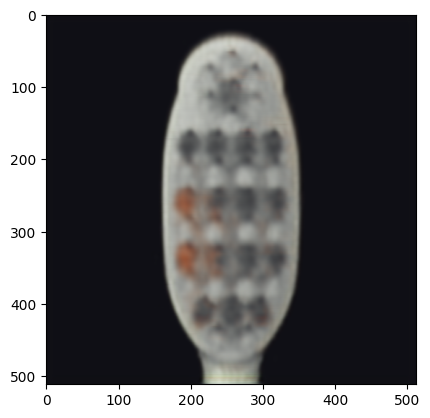

In [56]:
with torch.no_grad():
    plt.imshow(reconstructions[38].cpu().numpy()[0].transpose(1, 2, 0))

In [91]:
_ = model.train(False)

torch.save(model.state_dict(), f'./VT_AE_Mvtech.pt')

In [9]:
model = VT_AE().cuda()

model.load_state_dict(torch.load(f'./VT_AE_Mvtech.pt'))

<All keys matched successfully>

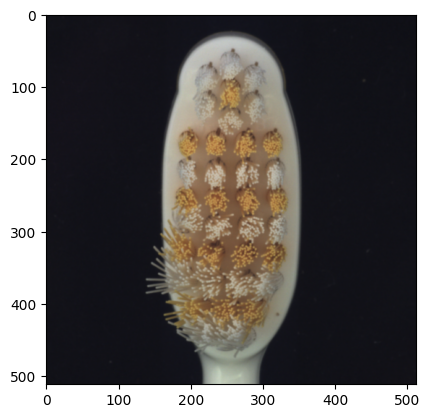

In [49]:
test_image, mask = test_dataset.__getitem__(25)

test_image = test_image.unsqueeze(0).cuda()

plt.imshow(test_image.cpu().numpy()[0].transpose(1, 2, 0))

In [50]:
from metrics.SSIM import SSIM


ssim = SSIM()

encoded, reconstruction = model(test_image)

mse = F.mse_loss(reconstruction, test_image, reduction='mean')
ssim_loss, ssim_map = ssim(test_image, reconstruction)

mse, ssim_loss, ssim_map.shape

(tensor(0.0029, device='cuda:0', grad_fn=<MseLossBackward0>),
 tensor(0.8583, device='cuda:0', grad_fn=<MeanBackward0>),
 torch.Size([1, 3, 512, 512]))

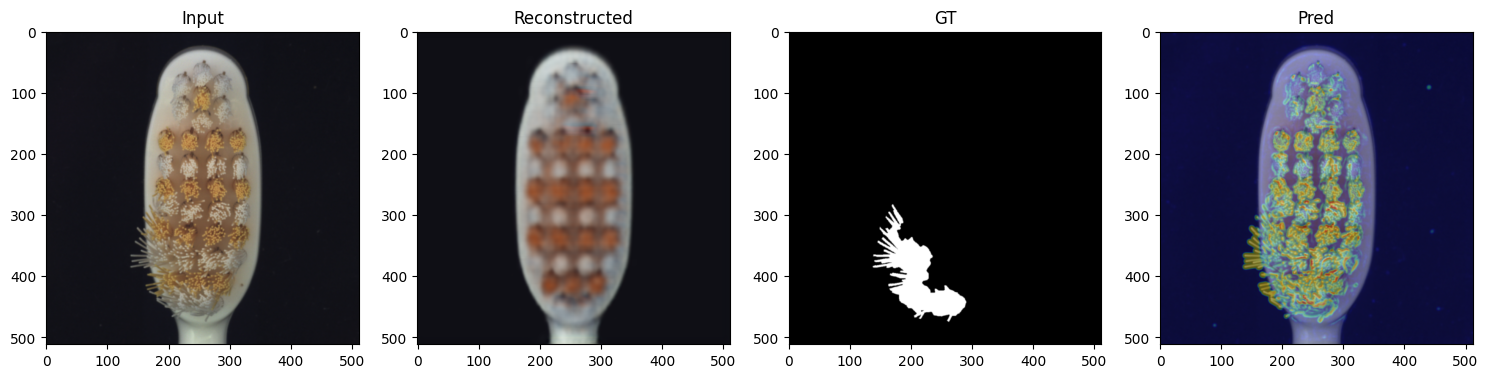

In [65]:
with torch.no_grad():
      # SSIM map assumed to be in the first channel
    _input_image = test_image.cpu().numpy()[0].transpose(1, 2, 0)
    _mask = mask.cpu().numpy().transpose(1, 2, 0)
    _ssim_map = ssim_map.cpu().numpy()[0][0]

    # Normalize the SSIM map
    ssim_map_norm = (_ssim_map - _ssim_map.min()) / (_ssim_map.max() - _ssim_map.min())

    threshold_value = -0.5  # Example threshold value, adjust as needed
    ssim_map_norm = np.where(ssim_map_norm < threshold_value, 0, ssim_map_norm)

    # Create a heatmap from the normalized SSIM map
    heatmap = cv2.applyColorMap((ssim_map_norm * 255).astype(np.uint8), cv2.COLORMAP_JET)

    # Convert _input_image to uint8
    _input_image_uint8 = (_input_image * 255).astype(np.uint8)

    # Overlay the heatmap on the original input image
    overlay = cv2.addWeighted(_input_image_uint8, 0.7, heatmap, 0.3, 0)

    # Plot the results

    fig = plt.figure(figsize=(15, 5))

    ax1 = fig.add_subplot(141)
    ax1.imshow(_input_image)
    ax1.set_title('Input')
    
    ax2 = fig.add_subplot(142)
    ax2.imshow(reconstruction.cpu().numpy()[0].transpose(1, 2, 0))
    ax2.set_title('Reconstructed')
    
    ax3 = fig.add_subplot(143)
    ax3.imshow(_mask, cmap='gray')
    ax3.set_title('GT')
    
    ax4 = fig.add_subplot(144)
    ax4.imshow(overlay)
    ax4.set_title('Pred')
    
    plt.tight_layout()
    plt.show()

error: OpenCV(4.9.0) /io/opencv/modules/imgproc/src/colormap.cpp:738: error: (-2:Unspecified error) in function 'void cv::colormap::ColorMap::operator()(cv::InputArray, cv::OutputArray) const'
> Not supported (expected: 'src.dims == 2'), where
>     'src.dims' is 4
> must be equal to
>     '2' is 2


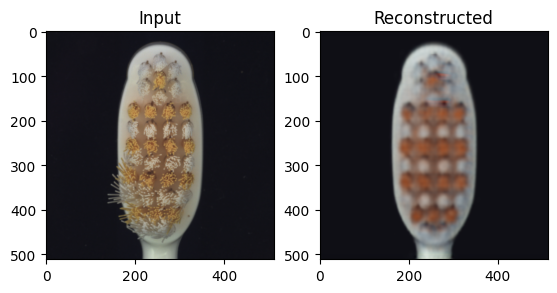

In [25]:
with torch.no_grad():
    fig = plt.figure(figsize=(10, 5))

    ax1 = fig.add_subplot(131)
    ax1.imshow(test_image.cpu().numpy()[0].transpose(1, 2, 0))
    ax1.set_title('Input')
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(reconstruction.cpu().numpy()[0].transpose(1, 2, 0))
    ax2.set_title('Reconstructed')
    
    ax3 = fig.add_subplot(133)
    ax3.imshow(ssim_map.cpu().numpy()[0].transpose(1, 2, 0))
    ax3.set_title('SSIM map')
    
    # plt.imshow(ssim_map.cpu().numpy()[0].transpose(1, 2, 0))
    plt.tight_layout()
    
    plt.show()